In [1]:
import matplotlib.pyplot as plt
import xtrack as xt
import scipy as sc
import bpmeth
import sympy as sp
import math
import numpy as np
from cpymad.madx import Madx
from sympy.abc import alpha, beta  # Cool notebook greek letters!
import sys
import warnings

In [2]:
##########################
# ELENA lattice in MAD-X #
##########################

madx = Madx()
madx.call("acc-models-elena/elena.seq")
madx.call("acc-models-elena/elena.dbx")
madx.call("acc-models-elena/tools/splitEle_installBPM.madx")
madx.call("acc-models-elena/scenarios/highenergy/highenergy.str")
madx.call("acc-models-elena/scenarios/highenergy/highenergy.beam")
madx.use("elena")


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2025.10.17 15:10:21      +
  ++++++++++++++++++++++++++++++++++++++++++++
! ELENA ring Sequence -> LNR

!

!

! Changelog:

! -  5/06/2018: started with Pavel''s optics

!   - cleaned up some commented lines and added some markers

!   - redefined randomly some names of the e-cool solenoids

!   - TODO: 

!      - cleanup useless lines. re-arrange markers "badly" used here and there.

!      - rename non-existing quad 631 and 626 !!!

! - 24/11/2020: adjusted structure to new standards. Still a lot of work to do to make it LDB compatible.

! - Sep 2021: moving toward LDB-compatible model

!

! TODO: probably need to work on arc lenght for dipoles to match GEODE/drawings/LDB.





/************************************************************************************/

/*            

In [3]:
#########################
# ELENA model in XSuite #
#########################

line = xt.Line.from_madx_sequence(madx.sequence.elena, deferred_expressions=True)
start_elem = "lnr.vvgbf.0114"
line.cycle(name_first_element=start_elem, inplace=True)  # Such that dipole is not spanning over end-beginning of lattice
line.particle_ref = xt.Particles(p0c=0.1e6, mass0=0.938272e6, q0=1)
line.configure_bend_model(core='adaptive', edge='full')
tw = line.twiss4d()

Converting sequence "elena": 100%|██████████| 191/191 [00:00<00:00, 1135.75it/s]


In [4]:
########################################################
# Resonance driving terms from hamiltonian terms hpqrt #
########################################################

def f(h_func, p, q, r, t, s, mux, muy, tw):
    # Ensure arrays
    s = np.asarray(s)
    mux = np.asarray(mux)
    muy = np.asarray(muy)
    
    # Common factors
    base = h_func(p,q,r,t, tw.s, tw.alfx, tw.alfy, tw.betx, tw.bety) / (1 - np.exp(2 * np.pi * 1j * ((p-q)*tw.qx+(r-t)*tw.qy)))

    # Exponent term depends on each mux value
    exp_term = np.exp(1j * 2*np.pi* ((p-q)*(tw.mux[:, None] - mux[None, :] 
                                            + tw.qx*((tw.mux[:, None] - mux[None, :]) < 0))
                                     + (r-t)*(tw.muy[:, None] - muy[None, :]
                                            + tw.qy*((tw.muy[:, None] - muy[None, :]) < 0))
                                     ))  # shape (len(tw.s), len(mux))

    # Integrand for each mux value → integrate along tw.s
    integrand = base[:, None] * exp_term

    # Integrate along s for each mux
    vals = np.trapezoid(integrand, x=tw.s, axis=0)

    return vals

#### RDTs for dipole component fringe fields

In [5]:
############################
# Magnet design parameters #
############################

phi = 60/180*np.pi
rho = 0.927  # https://edms.cern.ch/ui/file/1311860/2.0/LNA-MBHEK-ER-0001-20-00.pdf
dipole_h = 1/rho
l_magn = rho*phi
gap=0.076
theta_E = 17/180*np.pi
fint = 0.424
design_field_tesla = 0.42881

In [6]:
################
# Dipole model #
################

data_Melvin = np.loadtxt("../dipole/ELENA_fieldmap.csv", skiprows=1, delimiter=",")[:, [0,1,2,7,8,9]]
magnet_Melvin = bpmeth.Fieldmap(data_Melvin)

radius=0.0025
magnet_Melvin_FS = magnet_Melvin.calc_FS_coords(XFS = np.linspace(-0.025, 0.025, 51), YFS=[0], 
                                                SFS=np.arange(-0.75, 0.75, 0.001), rho=rho, phi=phi, 
                                                radius=radius)
magnet_Melvin_FS.rescale(dipole_h / design_field_tesla)  # Change units to 1/m^n instead of tesla


In [7]:
##########################################
# Fit Enge parameters to Melvin fieldmap #
##########################################

guess = [dipole_h, -3.79711153e+02, -1.07228082e+02, -2.74546491e+01, 3.79013318e-01]
engeparams, engecov = magnet_Melvin_FS.fit_multipoles(bpmeth.spEnge, components=[1], design=1, 
                                                      nparams=5, guess=guess,
                                                      entrance=True, design_field=dipole_h, 
                                                      zedge=-l_magn/2, zmax=0)

fitting b1...


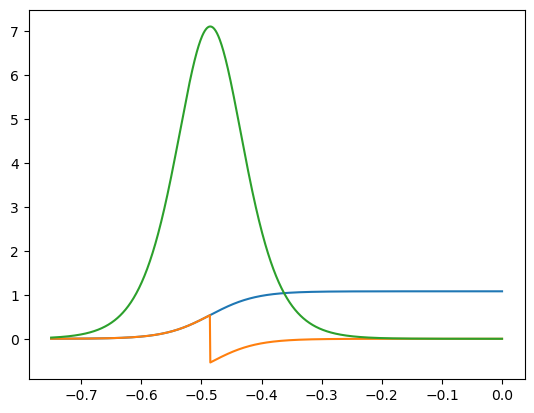

In [8]:
###########################################
# Create perturbing fields for one dipole #
###########################################

# def b1_magnet(s):
#     return (bpmeth.Enge(s+l_magn/2, *engeparams[0]) 
#             + bpmeth.Enge(-(s-l_magn/2), *engeparams[0])) - dipole_h

fringelen=gap
def b1_magnet(s):
    return (np.tanh( (s+l_magn/2)/fringelen ) + np.tanh( -(s-l_magn/2)/fringelen )) * dipole_h/2

def b1_pert_magnet(s):
    return b1_magnet(s) - (np.heaviside(s+l_magn/2, 0.5) - np.heaviside(s-l_magn/2, 0.5)) * dipole_h

def b1_magnet_der(s):
    return dipole_h / (2 * fringelen) * (1 / np.cosh((s + l_magn/2) / fringelen)**2 
                                         - 1 / np.cosh((-s + l_magn/2) / fringelen)**2)
    
def b1_magnet_2der(s):
    warnings.warn("Second derivative not implemented yet")
    return 0  # To be changed if second derivative is needed
    
ss = np.linspace(-0.75, 0, 1001)
fig, ax = plt.subplots()
ax.plot(ss, b1_magnet(ss), label='fit')
ax.plot(ss, b1_pert_magnet(ss), label='perturbation')
ax.plot(ss, b1_magnet_der(ss), label='1st der')

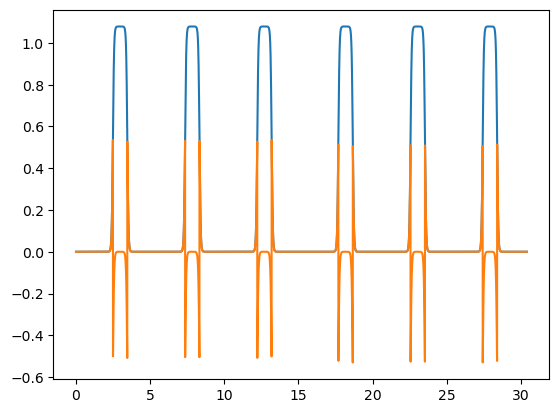

In [9]:
##########################################
# Create perturbing field for whole ring #
##########################################

tab = line.get_table()
dipole_centers = np.fromiter(set(tab['s_start'][tab["element_type"] == 'Bend']) & \
    set(tab['s_end'][tab["element_type"] == 'Bend']), float)

def b1_ring(s):
    s = np.asarray(s)  # ensure array input
    total = np.zeros_like(s, dtype=float)
    for dc in dipole_centers:
        total += b1_magnet(s - dc)
    return total

def b1_pert_ring(s):
    s = np.asarray(s)  # ensure array input
    total = np.zeros_like(s, dtype=float)
    for dc in dipole_centers:
        total += b1_pert_magnet(s - dc)
    return total

def b1_ring_der(s):
    s = np.asarray(s)  # ensure array input
    total = np.zeros_like(s, dtype=float)
    for dc in dipole_centers:
        total += b1_magnet_der(s - dc)
    return total

def b1_ring_2der(s):
    s = np.asarray(s)  # ensure array input
    total = np.zeros_like(s, dtype=float)
    for dc in dipole_centers:
        total += b1_magnet_2der(s - dc)
    return total

ss = np.linspace(0, line.get_length(), 5000)
fig, ax = plt.subplots()
ax.plot(ss, b1_ring(ss), label='Full dipole model')
ax.plot(ss, b1_pert_ring(ss), label='Perturbation model')


In [10]:
#####################################
# Field expansion in straight frame #
# NEED TO INCLUDE CURVATURE HERE    #
#####################################

s = sp.symbols("s")
hs = sp.symbols("hs")
b1 = sp.Function("b1")(s)

dip_straight = bpmeth.FieldExpansion(b=(b1, ))
dip_curved = bpmeth.FieldExpansion(b=(b1, ), hs=hs)

###################################
# Symbolically calculate the RDTs #
###################################

order = 3
betx, bety, alphx, alphy = sp.symbols("beta_x beta_y alpha_x alpha_y")
h_dip_straight = dip_straight.calc_RDTs(order, betx=betx, bety=bety, alphx=alphx, alphy=alphy)
h_dip_curved = dip_curved.calc_RDTs(order, betx=betx, bety=bety, alphx=alphx, alphy=alphy)

In [11]:
#####################################################
# Transform the symbolic expressions into functions #
#####################################################

b10, b11, b12 = sp.symbols("b10 b11 b12")
subs_set = {dip_straight.b[0]:b10, 
            sp.Derivative(dip_straight.b[0], dip_straight.s): b11, 
            sp.Derivative(dip_straight.b[0], dip_straight.s, dip_straight.s): b12}

h_fringe_array = np.empty_like(h_dip_straight, dtype=object)
for index, expr in np.ndenumerate(h_dip_straight):
    if expr !=0:
        h_fringe_array[index] = sp.lambdify((alphx, alphy, betx, bety, b10, b11, b12), 
                                          expr.subs(subs_set), modules='numpy')
    else:
        h_fringe_array[index] = 0
        
def h_fringe(p, q, r, t, s, alphx, alphy, betx, bety):
    """
    Vectorized numerical evaluation of h[p,q,r,t].
    All arguments (alphx, alphy, betx, bety, s) can be NumPy arrays of the same shape.
    """

    b10_val, b11_val, b12_val = b1_pert_ring(s), b1_ring_der(s), b1_ring_2der(s)
    return h_fringe_array[p, q, r, t](alphx, alphy, betx, bety, b10_val, b11_val, b12_val)

In [12]:
##########################################################
# Example: the closed orbit distortion from f1000, f0100 #
##########################################################

def deltax(s, mux, muy, betx, tw):
    return -np.sqrt(betx) * 1j * (f(h_fringe, 0,1,0,0,s, mux, muy, tw) - f(h_fringe, 1,0,0,0,s, mux, muy, tw))

Slicing line: 100%|██████████| 2838/2838 [00:00<00:00, 844035.65it/s]


(2.0, 4.0)

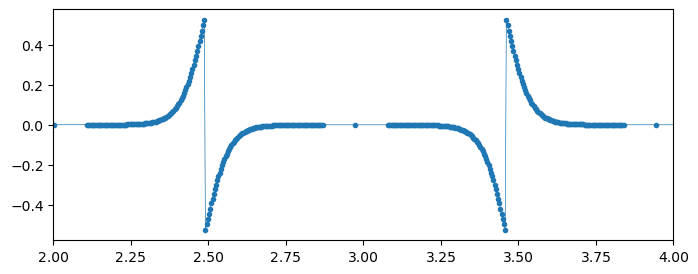

In [13]:
##########################################
# Plot closed orbit distortion for all s #
##########################################

line_sliced = line.copy()

# Evenly spaced around dipole edges. Cancellations play a role, 
# so symmetry is important - we don't want to include a net dipole field!
ns = 200
s_to_slice = np.array([[np.linspace(dc - l_magn/2 - 5*fringelen, dc - l_magn/2 + 5*fringelen, ns) for dc in dipole_centers], 
                       [np.linspace(dc + l_magn/2 - 5*fringelen, dc + l_magn/2 + 5*fringelen, ns) for dc in dipole_centers], 
                       ]).flatten()
s_to_slice = np.append(s_to_slice, [(dipole_centers+i*l_magn, dipole_centers-i*l_magn) for i in np.linspace(1, 2.5, 7)])
s_to_slice = np.sort(np.append(s_to_slice, dipole_centers))

line_sliced.cut_at_s(s_to_slice)
tw = line_sliced.twiss4d(at_s = s_to_slice)

# Inspect points around first dipole
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(tw.s, b1_pert_ring(tw.s), marker='.', linewidth=0.5)
ax.set_xlim(2, 4)

/tmp/silke/ipykernel_665710/2656927208.py:17: RuntimeWarning: overflow encountered in square
  return dipole_h / (2 * fringelen) * (1 / np.cosh((s + l_magn/2) / fringelen)**2
/tmp/silke/ipykernel_665710/2656927208.py:18: RuntimeWarning: overflow encountered in square
  - 1 / np.cosh((-s + l_magn/2) / fringelen)**2)
/tmp/silke/ipykernel_665710/2656927208.py:21: UserWarning: Second derivative not implemented yet
  warnings.warn("Second derivative not implemented yet")


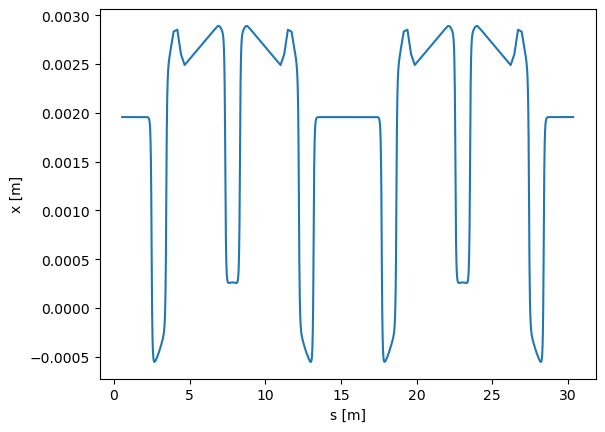

In [42]:
################################
# Plot closed orbit distortion #
################################

fig, ax = plt.subplots()
ax.plot(tw.s, deltax(tw.s, tw.mux, tw.muy, tw.betx, tw).real, label='closed orbit distortion')
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
plt.savefig("figures/ELENA_closed_orbit_distortion_due_to_dipole_fringes.png", dpi=300)


/tmp/silke/ipykernel_665710/2656927208.py:17: RuntimeWarning: overflow encountered in square
  return dipole_h / (2 * fringelen) * (1 / np.cosh((s + l_magn/2) / fringelen)**2
/tmp/silke/ipykernel_665710/2656927208.py:18: RuntimeWarning: overflow encountered in square
  - 1 / np.cosh((-s + l_magn/2) / fringelen)**2)
/tmp/silke/ipykernel_665710/2656927208.py:21: UserWarning: Second derivative not implemented yet
  warnings.warn("Second derivative not implemented yet")


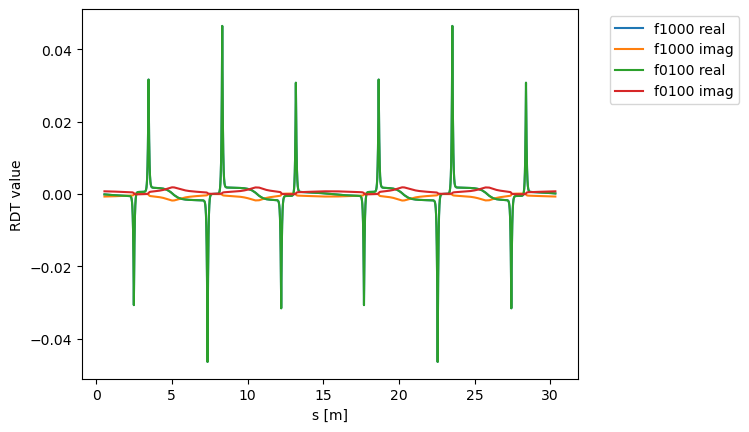

In [43]:
#####################################################
# Plot RDTs responsible for closed orbit distortion #
#####################################################

fig, ax = plt.subplots()
ax.plot(tw.s, f(h_fringe, 1,0,0,0, tw.s, tw.mux, tw.muy, tw).real, label="f1000 real")
ax.plot(tw.s, f(h_fringe, 1,0,0,0, tw.s, tw.mux, tw.muy, tw).imag, label="f1000 imag")
ax.plot(tw.s, f(h_fringe, 0,1,0,0, tw.s, tw.mux, tw.muy, tw).real, label="f0100 real")
ax.plot(tw.s, f(h_fringe, 0,1,0,0, tw.s, tw.mux, tw.muy, tw).imag, label="f0100 imag")
ax.set_xlabel('s [m]')
ax.set_ylabel('RDT value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

/tmp/silke/ipykernel_665710/2656927208.py:17: RuntimeWarning: overflow encountered in square
  return dipole_h / (2 * fringelen) * (1 / np.cosh((s + l_magn/2) / fringelen)**2
/tmp/silke/ipykernel_665710/2656927208.py:18: RuntimeWarning: overflow encountered in square
  - 1 / np.cosh((-s + l_magn/2) / fringelen)**2)
/tmp/silke/ipykernel_665710/2656927208.py:21: UserWarning: Second derivative not implemented yet
  warnings.warn("Second derivative not implemented yet")


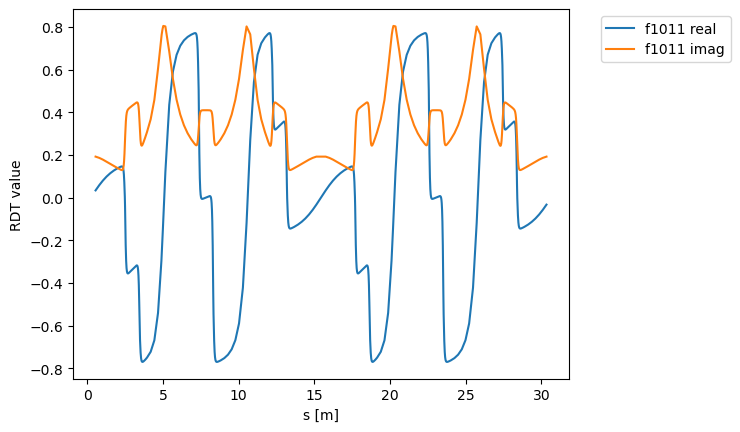

In [44]:
fig, ax = plt.subplots()
ax.plot(tw.s, f(h_fringe, 1,0,1,1, tw.s, tw.mux, tw.muy, tw).real, label="f1011 real")
ax.plot(tw.s, f(h_fringe, 1,0,1,1, tw.s, tw.mux, tw.muy, tw).imag, label="f1011 imag")
ax.set_xlabel('s [m]')
ax.set_ylabel('RDT value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

/tmp/silke/ipykernel_665710/2656927208.py:17: RuntimeWarning: overflow encountered in square
  return dipole_h / (2 * fringelen) * (1 / np.cosh((s + l_magn/2) / fringelen)**2
/tmp/silke/ipykernel_665710/2656927208.py:18: RuntimeWarning: overflow encountered in square
  - 1 / np.cosh((-s + l_magn/2) / fringelen)**2)
/tmp/silke/ipykernel_665710/2656927208.py:21: UserWarning: Second derivative not implemented yet
  warnings.warn("Second derivative not implemented yet")


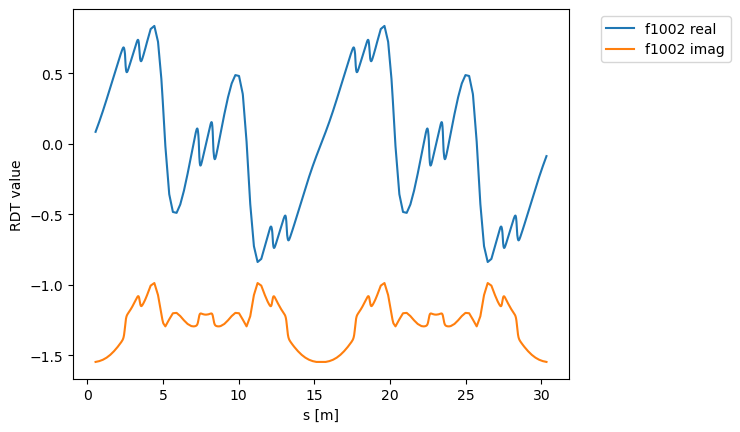

In [45]:
fig, ax = plt.subplots()
ax.plot(tw.s, f(h_fringe, 1,0,0,2, tw.s, tw.mux, tw.muy, tw).real, label="f1002 real")
ax.plot(tw.s, f(h_fringe, 1,0,0,2, tw.s, tw.mux, tw.muy, tw).imag, label="f1002 imag")
ax.set_xlabel('s [m]')
ax.set_ylabel('RDT value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#### Compare sextupole RDTs to the corresponding fringe field RDTs

In [18]:
######################################################
# Sextupole strength such that chromaticity is small #
######################################################

sext_k3_1 = 27.4
sext_k3_2 = -42.5
sext_length = line['lnr.mxnad.0525'].length
line_sext = line.copy()
line_sext["lnr.mxnad.0201"].knl[2] = sext_k3_1 * sext_length
line_sext["lnr.mxnad.0220"].knl[2] = sext_k3_2 * sext_length
line_sext["lnr.mxnad.0505"].knl[2] = sext_k3_1 * sext_length
line_sext["lnr.mxnad.0525"].knl[2] = sext_k3_2 * sext_length

tw_sext = line_sext.twiss4d()
print("Old chromaticity x: ", tw.dqx)
print("New chromaticity x: ", tw_sext.dqx)
print("Relative chromaticity change: ", (tw.dqx - tw_sext.dqx)/tw_sext.dqx)
print("Old chromaticity y: ", tw.dqy)
print("New chromaticity y: ", tw_sext.dqy)
print("Relative chromaticity change: ", (tw.dqy - tw_sext.dqy)/tw_sext.dqy)

Old chromaticity x:  -2.74847150284252
New chromaticity x:  -0.0068731318414450016
Relative chromaticity change:  398.8863351157081
Old chromaticity y:  -1.7308546047845041
New chromaticity y:  -0.005904316813243327
Relative chromaticity change:  292.15069965456695


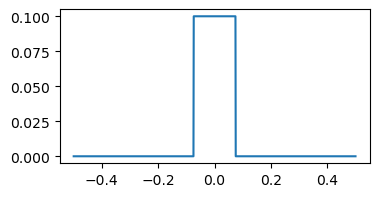

In [19]:
##############################################
# Create perturbing fields for one sextupole #
##############################################

def b3_magnet(s, k3val):
    return (np.heaviside(s+sext_length/2, 0.5) - np.heaviside(s-sext_length/2, 0.5))* k3val

ss = np.linspace(-0.5, 0.5, 1001)
fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(ss, b3_magnet(ss, 0.1), label='sextupole field')

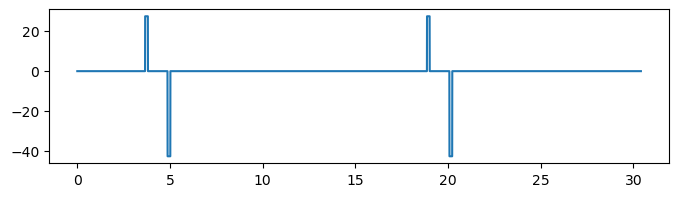

In [20]:
##########################################
# Create perturbing field for whole ring #
##########################################

tab = line.get_table()
sext_centers = tab['s_center'][tab["element_type"] == 'Sextupole']
sext_centers_fam1 = tab['s_center'][np.isin(tab["name"], ['lnr.mxnad.0201', 'lnr.mxnad.0505'])]
sext_centers_fam2 = tab['s_center'][np.isin(tab["name"], ['lnr.mxnad.0220', 'lnr.mxnad.0525'])]

def b3_ring(s):
    s = np.asarray(s)  # ensure array input
    total = np.zeros_like(s, dtype=float)
    for sc in sext_centers:
        total += b3_magnet(s - sc, sext_k3_1 if sc in sext_centers_fam1 else sext_k3_2)
    return total

ss = np.linspace(0, line.get_length(), 5000)
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(ss, b3_ring(ss), label='Full sextupole model')

In [21]:
sext_centers_fam1

array([ 3.73365213, 18.93630852])

In [22]:
#####################################
# Field expansion in straight frame #
# NEED TO INCLUDE CURVATURE HERE    #
#####################################

s = sp.symbols("s")
b3 = sp.Function("b3")(s)

sext_straight = bpmeth.FieldExpansion(b=("0", "0", b3))

###################################
# Symbolically calculate the RDTs #
###################################

order = 4
betx, bety, alphx, alphy = sp.symbols("beta_x beta_y alpha_x alpha_y")
h_sext_straight = sext_straight.calc_RDTs(order, betx=betx, bety=bety, alphx=alphx, alphy=alphy)

In [23]:
#####################################################
# Transform the symbolic expressions into functions #
#####################################################

b30 = sp.symbols("b30")
subs_set = {sext_straight.b[2]:b30, 
            sp.Derivative(sext_straight.b[2], sext_straight.s): 0, 
            sp.Derivative(sext_straight.b[2], sext_straight.s, sext_straight.s): 0}

h_sext_array = np.empty_like(h_sext_straight, dtype=object)
for index, expr in np.ndenumerate(h_sext_straight):
    if expr !=0:
        h_sext_array[index] = sp.lambdify((alphx, alphy, betx, bety, b30), 
                                          expr.subs(subs_set), modules='numpy')
    else:
        h_sext_array[index] = 0
        
def h_sextupole(p, q, r, t, s, alphx, alphy, betx, bety):
    """
    Vectorized numerical evaluation of h[p,q,r,t].
    All arguments (alphx, alphy, betx, bety, s) can be NumPy arrays of the same shape.
    """

    b30_val = b3_ring(s)
    return h_sext_array[p, q, r, t](alphx, alphy, betx, bety, b30_val)

In [24]:
##########################################
# Plot closed orbit distortion for all s #
##########################################

line_sliced = line.copy()

# Evenly spaced around dipole edges. Cancellations play a role, 
# so symmetry is important - we don't want to include a net dipole field!
ns = 200
s_to_slice = np.array([[np.linspace(dc - l_magn/2 - 5*fringelen, dc - l_magn/2 + 5*fringelen, ns) for dc in dipole_centers], 
                       [np.linspace(dc + l_magn/2 - 5*fringelen, dc + l_magn/2 + 5*fringelen, ns) for dc in dipole_centers], 
                       ]).flatten()
s_to_slice = np.append(s_to_slice, [np.linspace(sc - sext_length/2, sc + sext_length/2, ns) for sc in sext_centers])
s_to_slice = np.append(s_to_slice, [(dipole_centers+i*l_magn, dipole_centers-i*l_magn) for i in np.linspace(1, 2.5, 7)])
s_to_slice = np.sort(np.append(s_to_slice, dipole_centers))

line_sliced.cut_at_s(s_to_slice)
tw = line_sliced.twiss4d(at_s = s_to_slice)

Slicing line: 100%|██████████| 3630/3630 [00:00<00:00, 622051.13it/s]


/tmp/silke/ipykernel_665710/2656927208.py:17: RuntimeWarning: overflow encountered in square
  return dipole_h / (2 * fringelen) * (1 / np.cosh((s + l_magn/2) / fringelen)**2
/tmp/silke/ipykernel_665710/2656927208.py:18: RuntimeWarning: overflow encountered in square
  - 1 / np.cosh((-s + l_magn/2) / fringelen)**2)
/tmp/silke/ipykernel_665710/2656927208.py:21: UserWarning: Second derivative not implemented yet
  warnings.warn("Second derivative not implemented yet")


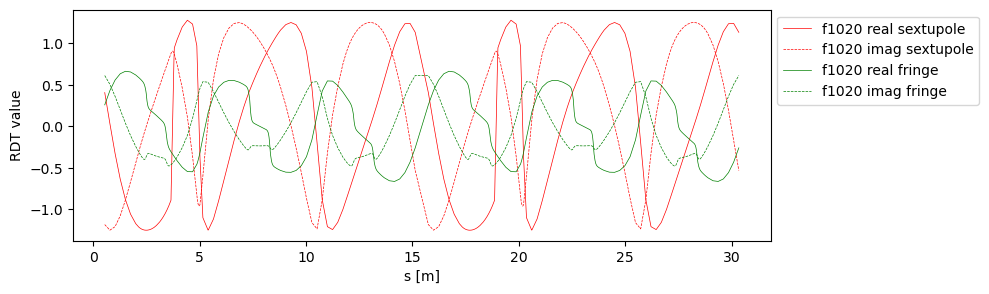

In [27]:
fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(tw.s, f(h_sextupole, 1,0,2,0, tw.s, tw.mux, tw.muy, tw).real, 
        linewidth=0.5, label="f1020 real sextupole", color="red", ls='-')
ax.plot(tw.s, f(h_sextupole, 1,0,2,0, tw.s, tw.mux, tw.muy, tw).imag, 
        linewidth=0.5, label="f1020 imag sextupole", color="red", ls='--')
ax.plot(tw.s, f(h_fringe, 1,0,2,0, tw.s, tw.mux, tw.muy, tw).real, 
        linewidth=0.5, label="f1020 real fringe", color="green", ls='-')
ax.plot(tw.s, f(h_fringe, 1,0,2,0, tw.s, tw.mux, tw.muy, tw).imag, 
        linewidth=0.5, label="f1020 imag fringe", color="green", ls='--')
ax.set_xlabel('s [m]')
ax.set_ylabel('RDT value')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

/tmp/silke/ipykernel_665710/2656927208.py:17: RuntimeWarning: overflow encountered in square
  return dipole_h / (2 * fringelen) * (1 / np.cosh((s + l_magn/2) / fringelen)**2
/tmp/silke/ipykernel_665710/2656927208.py:18: RuntimeWarning: overflow encountered in square
  - 1 / np.cosh((-s + l_magn/2) / fringelen)**2)
/tmp/silke/ipykernel_665710/2656927208.py:21: UserWarning: Second derivative not implemented yet
  warnings.warn("Second derivative not implemented yet")


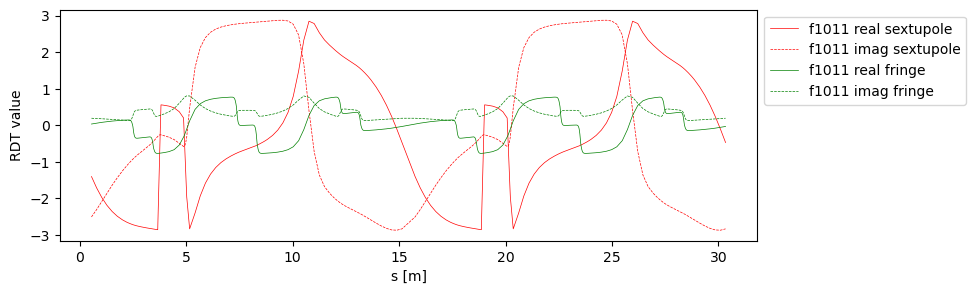

In [28]:
fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(tw.s, f(h_sextupole, 1,0,1,1, tw.s, tw.mux, tw.muy, tw).real, 
        linewidth=0.5, label="f1011 real sextupole", color="red", ls='-')
ax.plot(tw.s, f(h_sextupole, 1,0,1,1, tw.s, tw.mux, tw.muy, tw).imag, 
        linewidth=0.5, label="f1011 imag sextupole", color="red", ls='--')
ax.plot(tw.s, f(h_fringe, 1,0,1,1, tw.s, tw.mux, tw.muy, tw).real, 
        linewidth=0.5, label="f1011 real fringe", color="green", ls='-')
ax.plot(tw.s, f(h_fringe, 1,0,1,1, tw.s, tw.mux, tw.muy, tw).imag, 
        linewidth=0.5, label="f1011 imag fringe", color="green", ls='--')
ax.set_xlabel('s [m]')
ax.set_ylabel('RDT value')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')